In [1]:
import collections
import numpy as np
import pickle
import torch
from tqdm import tqdm
import wandb

import sys
sys.path.append('../')
import fmri_models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns

import matplotlib

matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(font="Arial", style="ticks")

In [2]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/17037 [00:00<?, ?it/s]

Found 17037


100%|██████████| 17037/17037 [02:37<00:00, 108.46it/s]


Normalize names.

In [3]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'monkeynets',
            'ShallowMonkeyNet_pvc4': 'monkeynets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'monkeynets',
            'dorsalnet': 'monkeynets',
            'airsim_00': 'monkeynets',
            'airsim_02': 'monkeynets',
            'airsim_03': 'monkeynets',
            'airsim_04': 'monkeynets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'monkeynets',
                    'airsim_00': 'monkeynets',
                    'airsim_02': 'monkeynets',
                    'airsim_03': 'monkeynets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
df.groupby(['dataset', 'subset_overall']).first()

,,key,family,subset,features,layer,features_layer,report_corr,max_r2,rnorm
dataset,subset_overall,,,,,,,,,
mst,36,I3D_layer00_mst_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.271957,0.961184,0.282940
mt1,84,MotionNet_layer00_mt1_norm_neutralbg_0,control,0,motionnet,0,motionnet_00,0.055997,1.000000,0.055997
mt2,44,MotionNet_layer00_mt2_0,control,0,motionnet,0,motionnet_00,0.186101,1.000000,0.186101
pvc1,23,I3D_layer00_pvc1-repeats_0,SlowFast,0,i3d,0,i3d_00,0.150142,0.757951,0.198090
pvc4,25,I3D_layer00_pvc4_0,SlowFast,0,i3d,0,i3d_00,0.709660,1.000000,0.709660


# Key measurements table

In [4]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)
    
    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]
    
    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

models = ['slowfast', 'i3d', 'r3d_18', 'r2plus1d_18', 'mc3_18',  'cpc_ucf', 'cpc_airsim', 'gaborpyramid3d_motionless', 'gaborpyramid3d',  'motionnet', 'dorsalnet']
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets].loc[models]
df_s = df_s[datasets].loc[models]
df_z = df_z[datasets].loc[models]
    
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.replace('_', '\_')]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")
                
    the_str += ' & '.join(vals) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
slowfast & \textbf{0.471} (0.034) & 0.361 (0.042) & 0.211 (0.018) & 0.281 (0.015) & -\\
i3d & \textbf{0.457} (0.036) & \textbf{0.389} (0.046) & - & - & 0.219 (0.044)\\
r3d\_18 & 0.403 (0.032) & \textbf{0.383} (0.042) & - & 0.289 (0.015) & 0.224 (0.046)\\
r2plus1d\_18 & 0.428 (0.035) & \textbf{0.382} (0.042) & - & 0.282 (0.015) & 0.226 (0.043)\\
mc3\_18 & 0.405 (0.034) & \textbf{0.393} (0.045) & - & 0.276 (0.014) & 0.228 (0.045)\\
cpc\_ucf & 0.271 (0.044) & \textbf{0.394} (0.046) & 0.214 (0.018) & 0.241 (0.016) & 0.190 (0.045)\\
cpc\_airsim & 0.422 (0.036) & \textbf{0.384} (0.045) & \textbf{0.250} (0.020) & 0.360 (0.017) & 0.292 (0.045)\\
gaborpyramid3d\_motionless & 0.273 (0.035) & 0.353 (0.038) & 0.212 (0.018) & 0.188 (0.014) & 0.248 (0.045)\\
gaborpyramid3d & 0.325 (0.036) & \textbf{0.366} (0.037) & \textbf{0.249} (0.019) & 0.301 (0.015) & 0.394 (0.054)\\
motionnet & 0.276 (0.042) & \textbf{0.364} (0.039

# Bump plot

<ipython-input-6-7d2c7988da25>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


1.1470625
0.16880878477132705
[0.83333333 1.14583333 1.5       ]


<ipython-input-6-7d2c7988da25>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.0477708661417324
0.11231924654041395
[1.82677165 2.04724409 2.26771654]


<ipython-input-6-7d2c7988da25>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.87315
0.2822348993967614
[2.3125  2.875   3.40625]


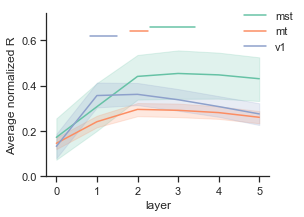

In [6]:
dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

df['area'] = df.dataset.map(lambda x: dmap[x])
df_ = df.query('features == "dorsalnet"')
df_ = df_.sort_values('area', ascending=True)

plt.figure(figsize=(4, 3))
g = sns.lineplot(x='layer', 
                y='rnorm', 
                hue='area',
                palette="Set2",
                data=df_, legend=True, ax=plt.gca())
sns.despine()
plt.legend(loc='upper right', fancybox=None, frameon=False, bbox_to_anchor=(0.,.97, 1.15, .105))
plt.ylabel('Average normalized R')

cols = sns.color_palette(as_cmap=True)
for i, area in enumerate(['v1', 'mt', 'mst']):
    df_ = df.query(f'report_corr > .01 and features == "dorsalnet" and area == "{area}"')
    df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
    v = df_.pivot('dataset_subset', 'layer', 'rnorm').values
    
    vals = []
    for n in range(10000):
        v_ = v[np.random.randint(low=0, high=v.shape[0], size=v.shape[0]), :].argmax(axis=1)#mean(axis=0)
        #cs = CubicSpline(np.arange(6), v_)
        #xs = np.linspace(0, 5)
        vals.append(v_.mean())
        
    print(np.mean(vals))
    print(np.std(vals))
    
    plt.plot(np.quantile(vals, [.025, .975]), (.62 + .02*i) * np.array([1, 1]), color=g.lines[2-i].get_color())
    print(np.quantile(vals, [.025, .5, .975]))
    
plt.ylim([0, .72])

plt.savefig('/home/pmin/paper-assets/figure2-layer-alignment.pdf', bbox_inches='tight')

''

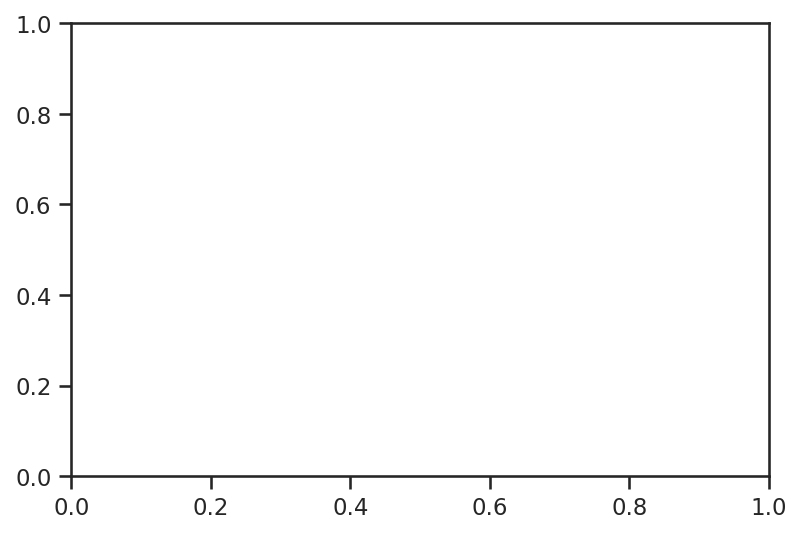

In [317]:
plt.gca().get_xlabel()

In [219]:
df_

,key,family,dataset,subset,features,layer,features_layer,report_corr,max_r2,rnorm,subset_overall,area
1504,airsim_04_layer00_pvc1-repeats_0,monkeynets,pvc1,0,dorsalnet,0,dorsalnet_00,0.078083,0.757951,0.103019,23,v1
1505,airsim_04_layer00_pvc1-repeats_1,monkeynets,pvc1,1,dorsalnet,0,dorsalnet_00,-0.086549,0.634206,-0.136468,23,v1
1506,airsim_04_layer00_pvc1-repeats_10,monkeynets,pvc1,10,dorsalnet,0,dorsalnet_00,-0.124293,0.650683,-0.191019,23,v1
1507,airsim_04_layer00_pvc1-repeats_11,monkeynets,pvc1,11,dorsalnet,0,dorsalnet_00,-0.004436,0.316228,-0.014028,23,v1
1508,airsim_04_layer00_pvc1-repeats_12,monkeynets,pvc1,12,dorsalnet,0,dorsalnet_00,0.243752,0.712994,0.341872,23,v1
...,...,...,...,...,...,...,...,...,...,...,...,...
2607,airsim_04_layer05_pvc4_5,monkeynets,pvc4,5,dorsalnet,5,dorsalnet_05,0.005907,1.000000,0.005907,25,v1
2608,airsim_04_layer05_pvc4_6,monkeynets,pvc4,6,dorsalnet,5,dorsalnet_05,0.045463,1.000000,0.045463,25,v1
2609,airsim_04_layer05_pvc4_7,monkeynets,pvc4,7,dorsalnet,5,dorsalnet_05,0.291631,1.000000,0.291631,25,v1
2610,airsim_04_layer05_pvc4_8,monkeynets,pvc4,8,dorsalnet,5,dorsalnet_05,0.391641,1.000000,0.391641,25,v1


<ipython-input-237-fdeb8d85fc6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
<ipython-input-237-fdeb8d85fc6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


<ipython-input-237-fdeb8d85fc6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


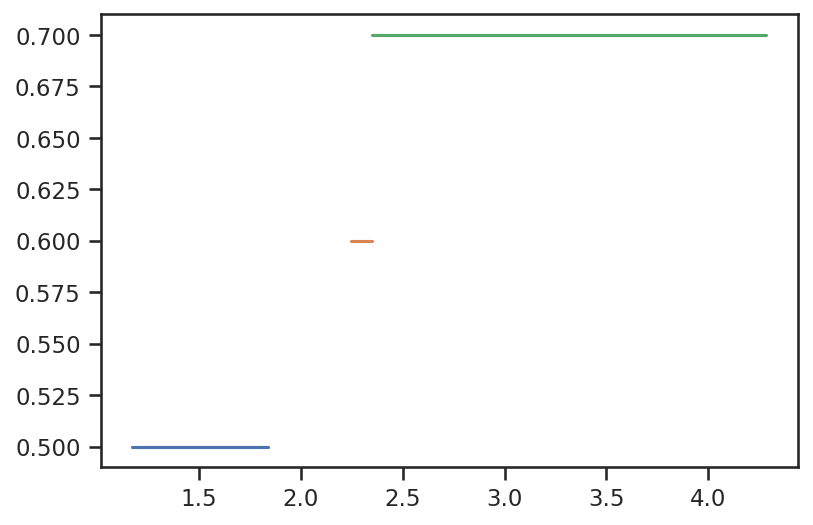

In [237]:
    print()
    


In [228]:
np.arange(6)

array([0, 1, 2, 3, 4, 5])

In [184]:
g.axes

<AxesSubplot:xlabel='layer', ylabel='rnorm'>

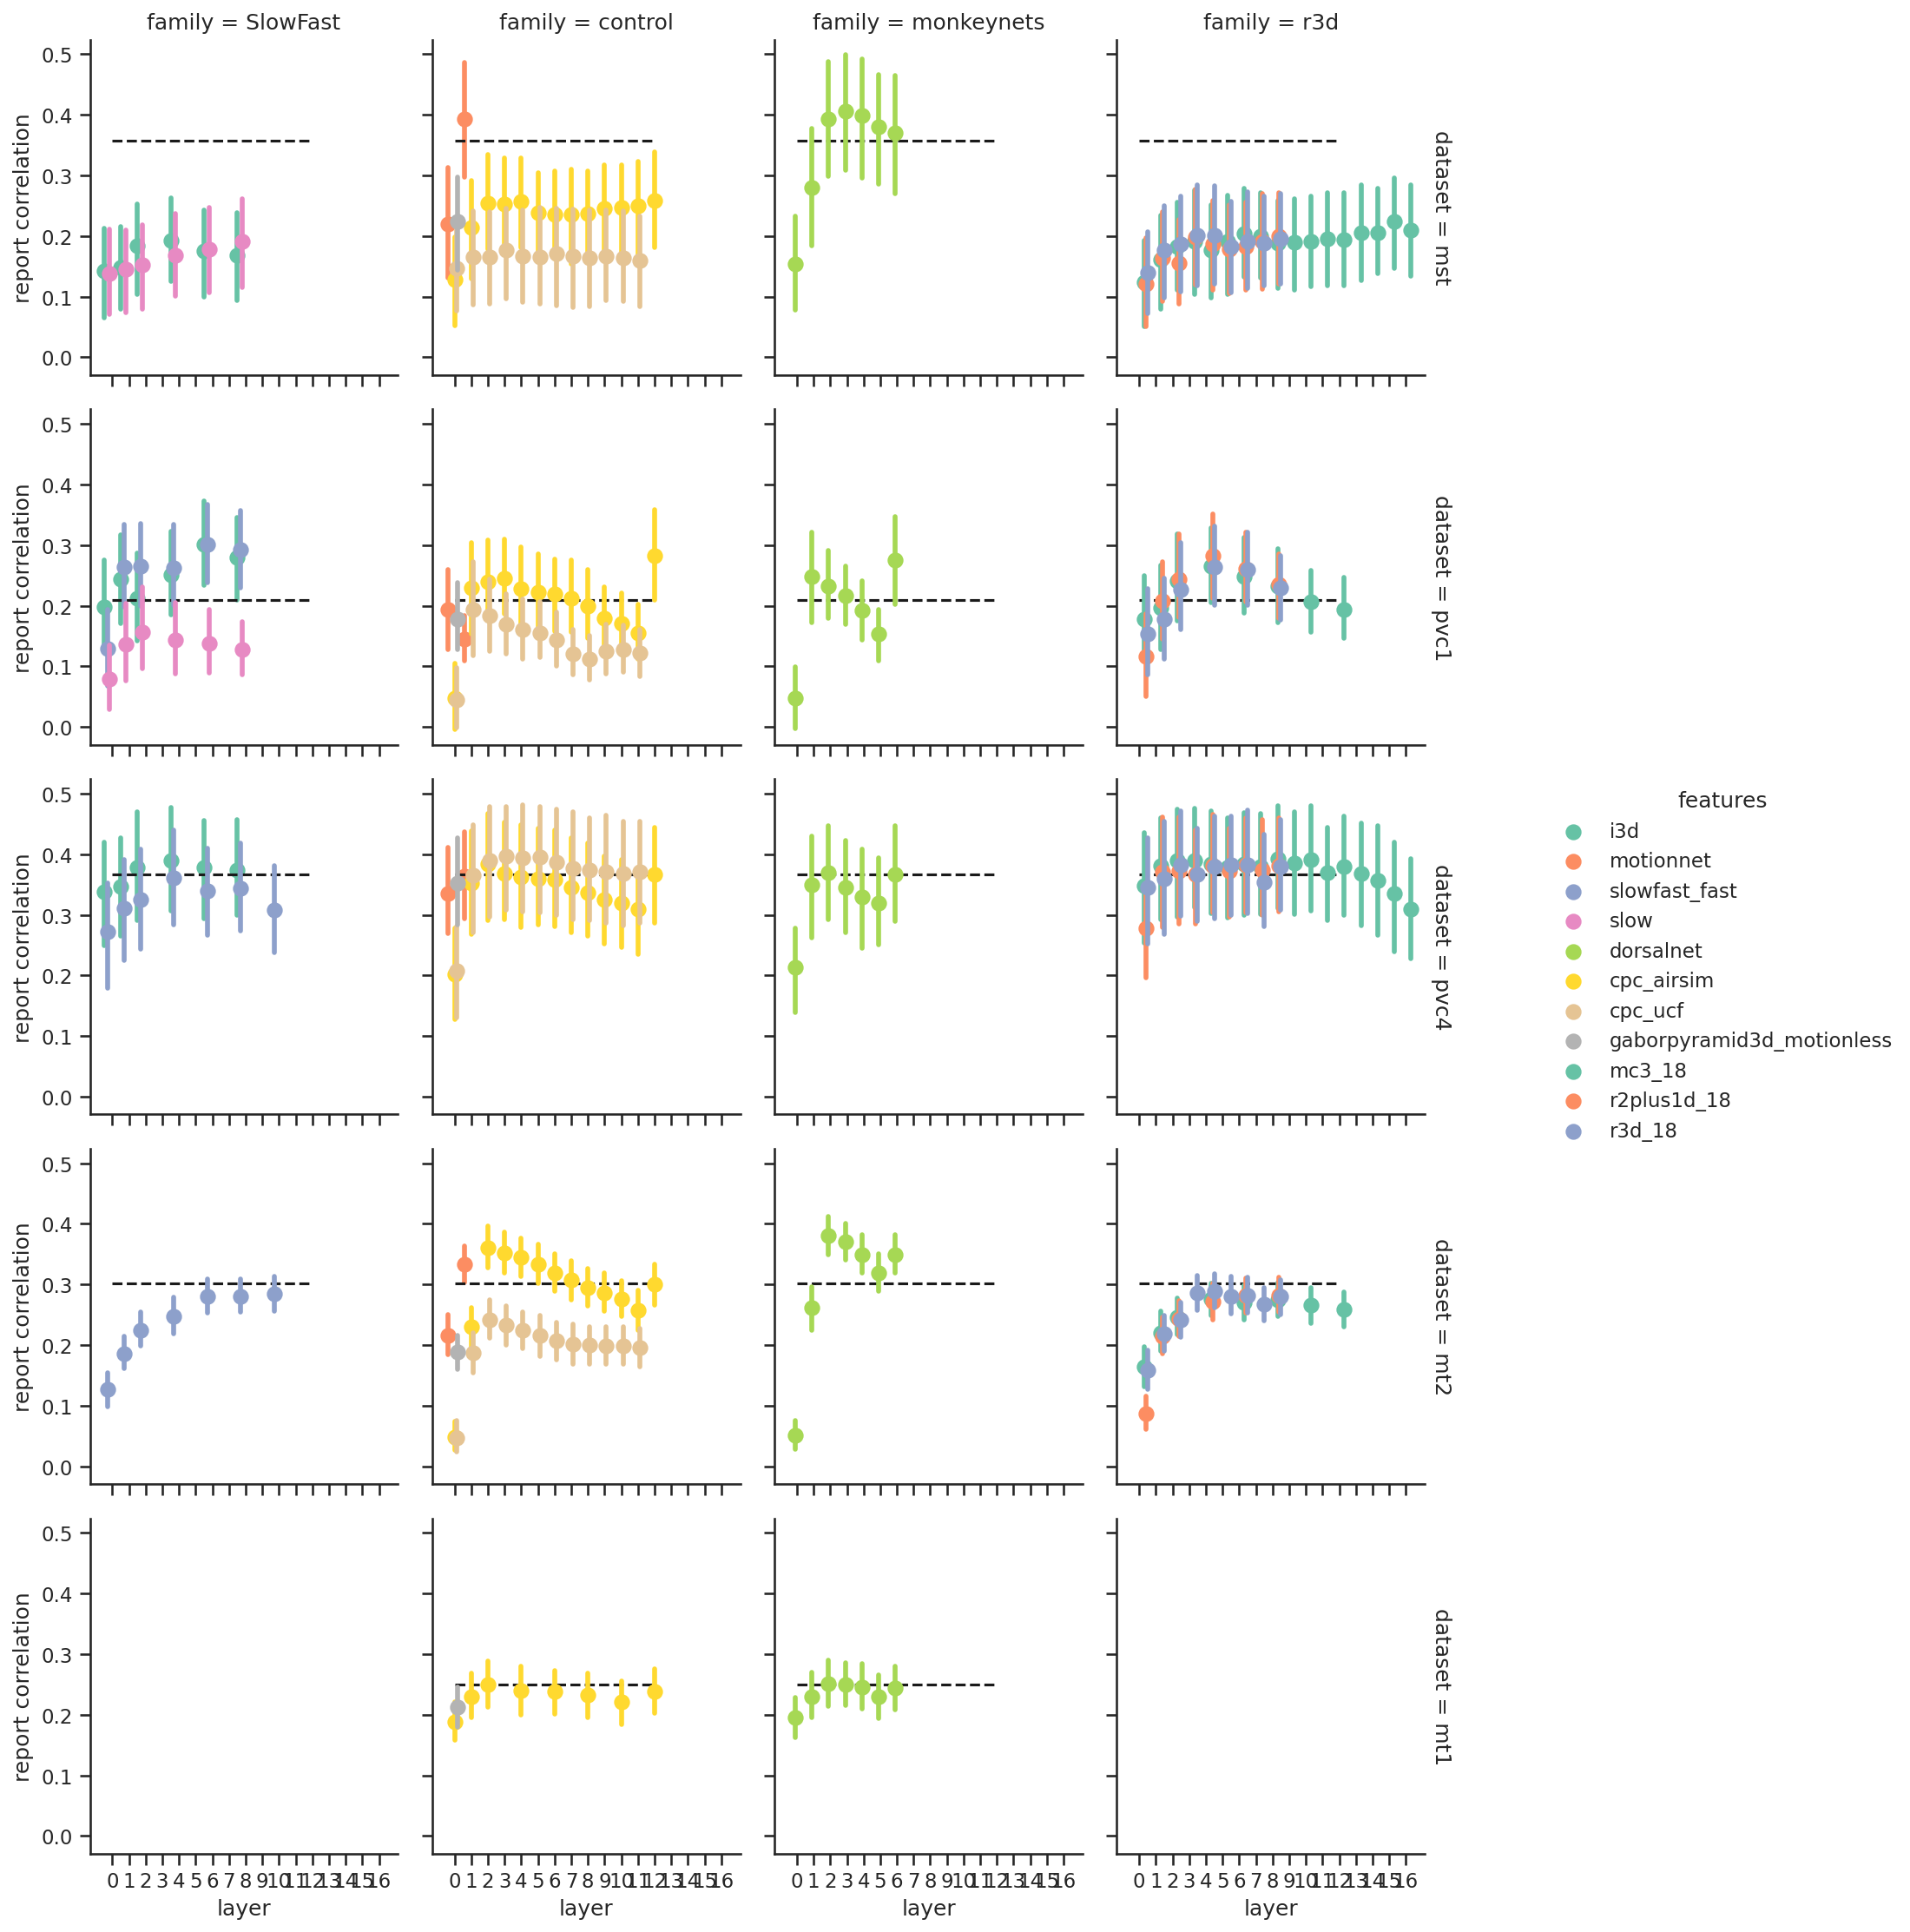

In [60]:
m = df.query('features == "gaborpyramid3d"').groupby('dataset').report_corr.mean()

def annotate(data, **kws):
    ax = plt.gca()
    # Plot the shallow baseline
    baseline = m[data.iloc[0].dataset]
    ax.plot([0, 12], [baseline, baseline], 'k--')

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="ticks")
g = sns.catplot(x='layer', 
             y='report_corr', 
             hue='features',
             col='family', 
             row='dataset',
             kind='point',
             palette="Set2",
             data=df.query('family != "shallow" and (family != "monkeynets" or features == "dorsalnet") and features != "cpc" and features != "ShiftNet"'),
             height=3,
             #legend_outside=False,
             join=False,
             dodge=1,
             margin_titles=True)
g.map_dataframe(annotate, panel=np.arange(3))
g.set_axis_labels("layer", "report correlation")

#plt.savefig('/home/pmin/paper-assets/prediction-results.png')

<ipython-input-153-3f8eaf85eec4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subset_offset'] = df_.subset + 1*(df.dataset == 'pvc4')
<ipython-input-153-3f8eaf85eec4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['ds'] = df_['subset_offset'].map(lambda x: df__.loc[x].ds)


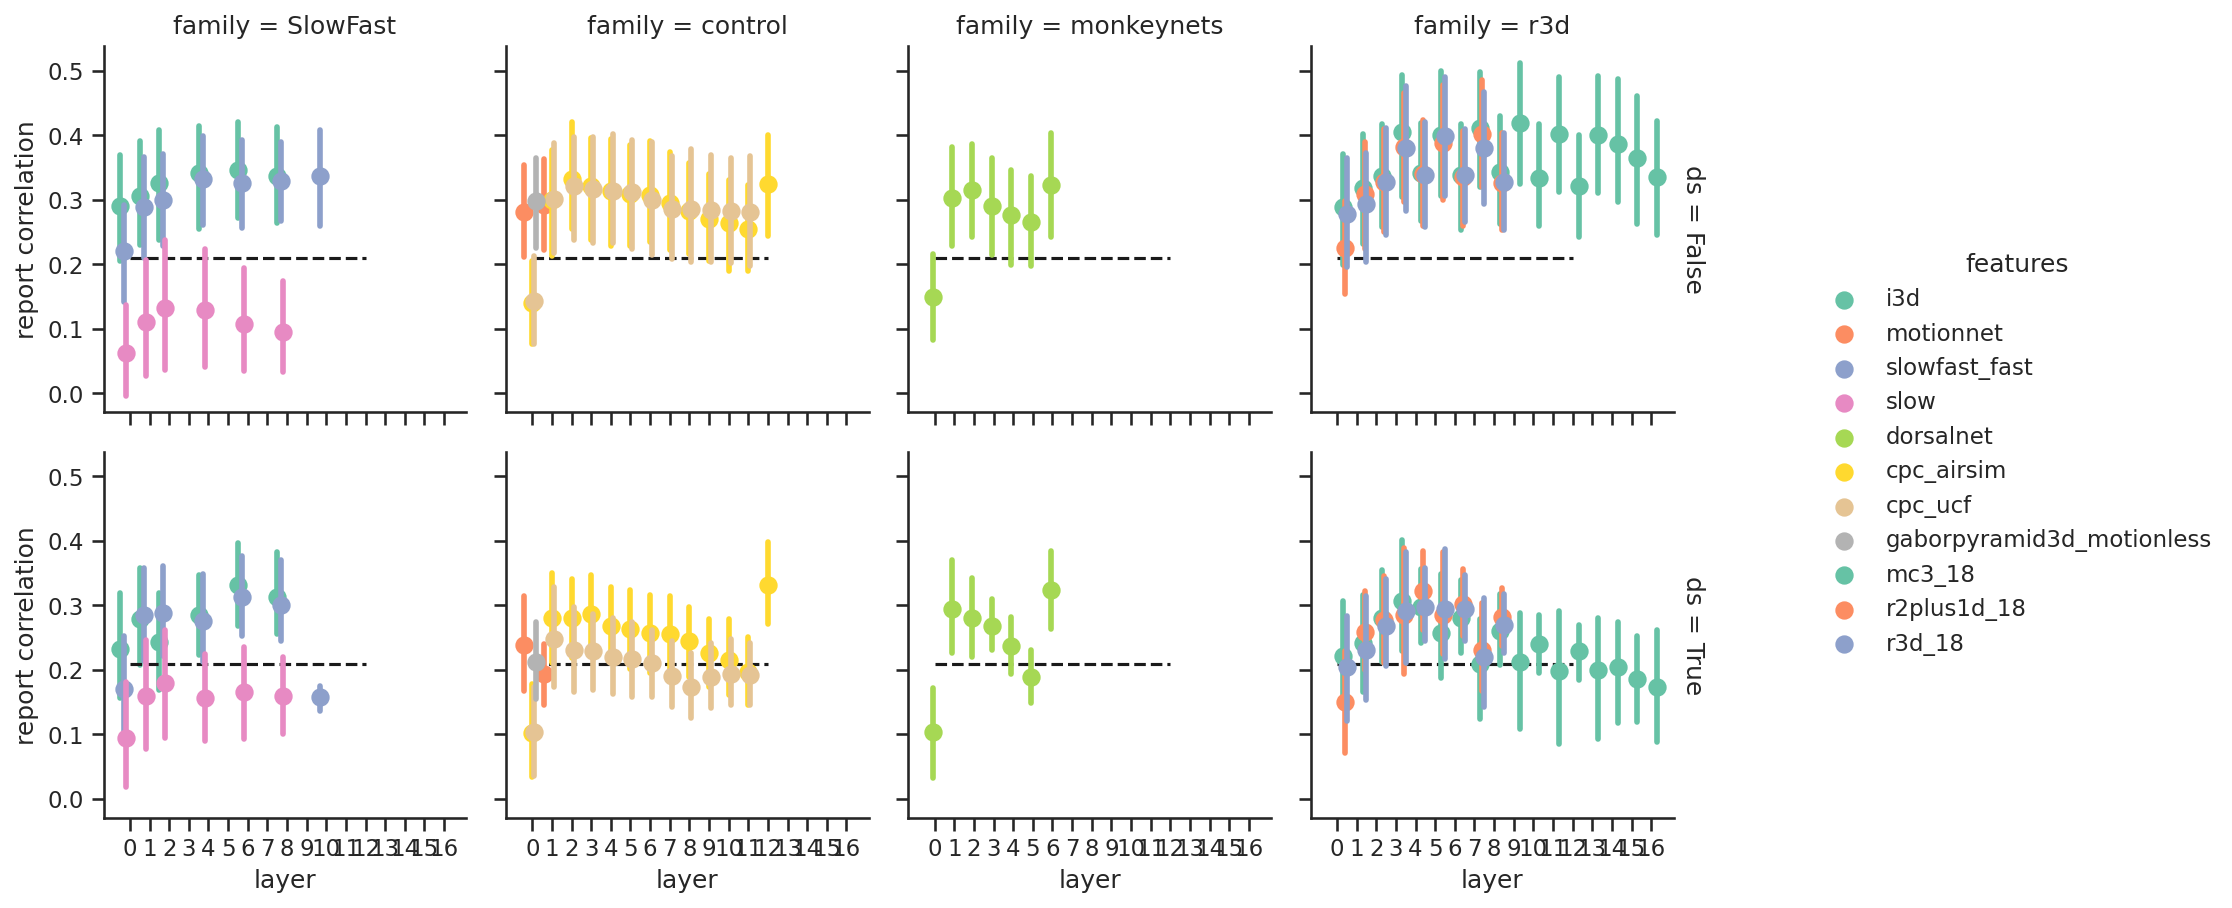

In [153]:
# Classify v1 cells into direction-selective and non-direction selective
df_ = df.query('dataset == "pvc1-repeats" or dataset == "pvc4"')
df_['subset_offset'] = df_.subset + 1*(df.dataset == 'pvc4')

df__ = df_.query('features == "gaborpyramid3d" or features == "gaborpyramid3d_motionless"').pivot('subset_offset', 'features', 'report_corr')
df__['ds'] = df__.gaborpyramid3d - df__.gaborpyramid3d_motionless > .03
df_['ds'] = df_['subset_offset'].map(lambda x: df__.loc[x].ds)

m = df.query('features == "gaborpyramid3d"').groupby('dataset').report_corr.mean()

def annotate(data, **kws):
    ax = plt.gca()
    # Plot the shallow baseline
    baseline = m[data.iloc[0].dataset]
    ax.plot([0, 12], [baseline, baseline], 'k--')

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="ticks")
g = sns.catplot(x='layer', 
             y='report_corr', 
             hue='features',
             col='family', 
             row='ds',
             kind='point',
             palette="Set2",
             data=df_.query('dataset != "dorsal_norm_neutralbg" and family != "shallow" and (family != "monkeynets" or features == "dorsalnet") and features != "cpc" and features != "ShiftNet"'),
             height=3,
             #legend_outside=False,
             join=False,
             dodge=1,
             margin_titles=True)
g.map_dataframe(annotate, panel=np.arange(3))
g.set_axis_labels("layer", "report correlation")

#plt.savefig('/home/pmin/paper-assets/prediction-results.png')

AttributeError: 'DataFrame' object has no attribute 'gaborpyramid3d_motionless_0'

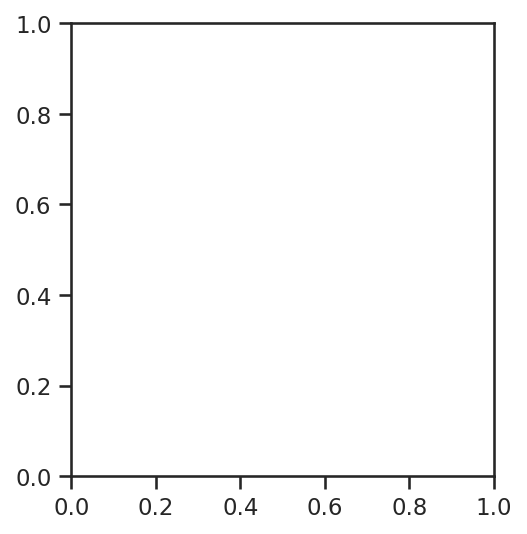

In [8]:
df['feature_layer'] = df['features'] + '_' + df['layer'].astype(str)
df_ = df.query('dataset == "pvc4"').pivot_table('report_corr', 'subset', 'feature_layer')

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(df_.gaborpyramid3d_motionless_0, df_.gaborpyramid3d_0, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel('3d gabor pyramid, no motion')
plt.ylabel('3d gabor pyramid, w motion')
plt.axis('square')

plt.subplot(122)
plt.plot(df_.gaborpyramid3d_0, df_.dorsalnet_5, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel('3d gabor pyramid, w motion')
plt.ylabel('DorsalNet')
plt.axis('square')

plt.suptitle('PVC4 model fits (correlation on report data)')

AttributeError: 'DataFrame' object has no attribute 'gaborpyramid3d_motionless_0'

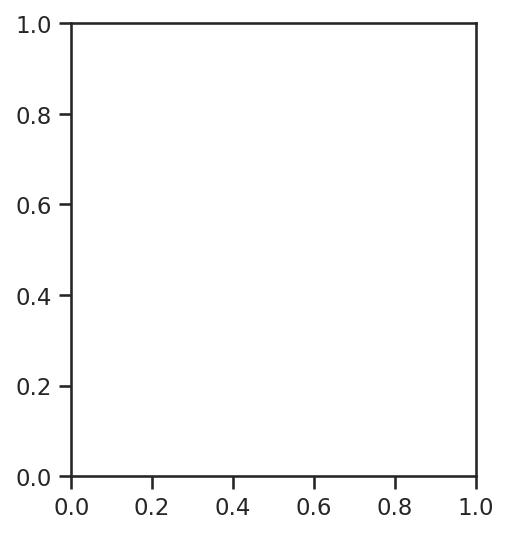

In [9]:
df['feature_layer'] = df['features'] + '_' + df['layer'].astype(str)
df_ = df.query('dataset == "mt2"').pivot_table('report_corr', 'subset', 'feature_layer')

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.plot(df_.gaborpyramid3d_motionless_0, df_.gaborpyramid3d_0, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(df_.gaborpyramid3d_motionless_0[::3], df_.gaborpyramid3d_0[::3], 'r.')
plt.plot([0, 1], [0, 1], 'k-')

plt.xlabel('3d gabor pyramid, no motion')
plt.ylabel('3d gabor pyramid, w motion')
plt.axis('square')

plt.subplot(142)
plt.plot(df_.gaborpyramid3d_0, df_.dorsalnet_5, '.')
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(df_.gaborpyramid3d_0[::3], df_.dorsalnet_5[::3], 'r.')
plt.xlabel('3d gabor pyramid, w motion')
plt.ylabel('DorsalNet')
plt.axis('square')

plt.subplot(143)
plt.plot(df_.gaborpyramid3d_0, df_.airsim_04_3, '.')
plt.plot([0, 1], [0, 1], 'k-')
#plt.plot(df_.gaborpyramid3d_0[::3], df_.dorsalnet_5[::3], 'r.')
plt.xlabel('3d gabor pyramid, w motion')
plt.ylabel('Airsim layer 3')
plt.axis('square')

plt.subplot(144)
plt.plot(df_.MotionNet_1, df_.airsim_04_3, '.')
plt.plot([0, 1], [0, 1], 'k-')
#plt.plot(df_.gaborpyramid3d_0[::3], df_.dorsalnet_5[::3], 'r.')
plt.xlabel('Motion Net 1')
plt.ylabel('DorsalNet')
plt.axis('square')

plt.suptitle('MT model fits (correlation on report data)')

In [39]:
df_.columns

Index(['I3D_0', 'I3D_1', 'I3D_2', 'I3D_3', 'I3D_4', 'I3D_5', 'MotionNet_0',
       'MotionNet_1', 'ShallowMonkeyNet_pvc1_0', 'ShallowMonkeyNet_pvc1_1',
       'ShiftNet_0', 'ShiftNet_1', 'ShiftNet_2', 'ShiftNet_3',
       'SlowFast_Fast_0', 'SlowFast_Fast_1', 'SlowFast_Fast_2',
       'SlowFast_Fast_3', 'SlowFast_Fast_4', 'SlowFast_Fast_5',
       'SlowFast_Fast_6', 'V1Net_0', 'V1Net_1', 'V1Net_2', 'V1Net_3',
       'airsim_00_0', 'airsim_00_1', 'airsim_00_2', 'airsim_00_3',
       'airsim_00_4', 'airsim_00_5', 'airsim_00_6', 'dorsalnet_0',
       'dorsalnet_1', 'dorsalnet_2', 'dorsalnet_3', 'dorsalnet_4',
       'dorsalnet_5', 'dorsalnet_6', 'gaborpyramid3d_0',
       'gaborpyramid3d_motionless_0', 'mc3_18_0', 'mc3_18_1', 'mc3_18_10',
       'mc3_18_11', 'mc3_18_12', 'mc3_18_13', 'mc3_18_14', 'mc3_18_15',
       'mc3_18_16', 'mc3_18_2', 'mc3_18_3', 'mc3_18_4', 'mc3_18_5', 'mc3_18_6',
       'mc3_18_7', 'mc3_18_8', 'mc3_18_9', 'r3d_18_0', 'r3d_18_1', 'r3d_18_2',
       'r3d_18_3', 'r3d

In [23]:
df_.gaborpyramid3d_motionless_0[::3]

subset
0     0.187699
3     0.119218
6     0.100751
9     0.118885
12    0.197210
15    0.187876
18    0.253567
21    0.160995
24    0.351813
27    0.284403
30    0.217410
33    0.215996
36    0.119049
39    0.008796
42    0.300288
Name: gaborpyramid3d_motionless_0, dtype: float64

In [73]:
df.query('family == "shallow"').groupby(['dataset', 'layer']).count()

key  family  subset  features  report_corr  layer_overall  \
dataset layer                                                              
mt2     0       43      43      43        43           43             43   
pvc4    0       75      75      75        75           75             75   
        1       50      50      50        50           50             50   

               subset_overall  
dataset layer                  
mt2     0                  43  
pvc4    0                  75  
        1                  50

,key,family,dataset,subset,features,layer,report_corr,subset_overall
6,ShallowMonkeyNet_pvc1_layer00_pvc4_0,monkeynets,pvc4,0,ShallowMonkeyNet_pvc1,0,0.376027,24
7,ShallowMonkeyNet_pvc1_layer00_pvc4_1,monkeynets,pvc4,1,ShallowMonkeyNet_pvc1,0,0.333355,24
8,ShallowMonkeyNet_pvc1_layer00_pvc4_10,monkeynets,pvc4,10,ShallowMonkeyNet_pvc1,0,-0.013845,24
9,ShallowMonkeyNet_pvc1_layer00_pvc4_11,monkeynets,pvc4,11,ShallowMonkeyNet_pvc1,0,0.028829,24
10,ShallowMonkeyNet_pvc1_layer00_pvc4_12,monkeynets,pvc4,12,ShallowMonkeyNet_pvc1,0,0.334089,24
...,...,...,...,...,...,...,...,...
987,gaborpyramid3d_layer00_v2_95,shallow,v2,95,gaborpyramid3d,0,0.025285,120
988,gaborpyramid3d_layer00_v2_96,shallow,v2,96,gaborpyramid3d,0,-0.080322,120
989,gaborpyramid3d_layer00_v2_97,shallow,v2,97,gaborpyramid3d,0,0.130078,120
990,gaborpyramid3d_layer00_v2_98,shallow,v2,98,gaborpyramid3d,0,0.198802,120


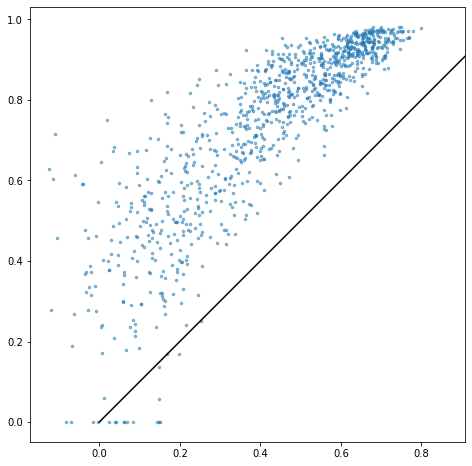

In [31]:
max_r = df.query('key == "Slow_res224_layer10" and area == "v1"').max_r
report_corr = df.query('key == "Slow_res224_layer10" and area == "v1"').report_corr

plt.figure(figsize=(8, 8))
plt.plot(report_corr, max_r, '.', markersize=5, alpha=0.5)
plt.axis('square')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel('Report corr')
plt.xlabel('Max corr')

In [41]:
df_2d.relative_r

Series([], Name: relative_r, dtype: float64)

Text(0.5, 1.0, 'Mean prediction normalized correlation')

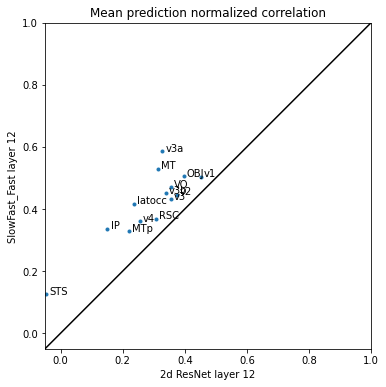

In [45]:
df_3d = df.query('features == "SlowFast_Fast_res224" and layer == 12 and max_r > .2').groupby('area').mean()
df_2d = df.query('features == "resnet18_res224" and layer == 12 and max_r > .2').groupby('area').mean()

plt.figure(figsize=(6, 6))
plt.plot(df_2d.relative_r, df_3d.relative_r, '.')
for i in range(len(df_2d)):
    plt.text(df_2d.relative_r[i]+.01, df_3d.relative_r[i], df_2d.reset_index().area[i])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.axis('square')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])

plt.xlabel('2d ResNet layer 12')
plt.ylabel('SlowFast_Fast layer 12')
plt.title('Mean prediction normalized correlation')

Text(0.5, 1.0, 'Mean prediction normalized correlation')

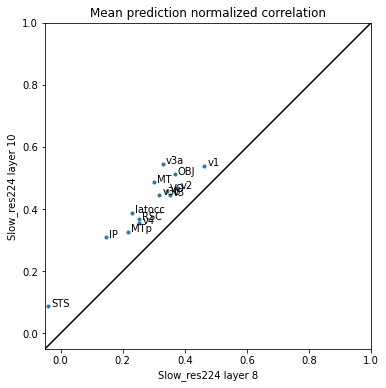

In [50]:
df_3d = df.query('features == "Slow_res224" and layer == 10 and max_r >= .2').groupby('area').mean()
df_2d = df.query('features == "Slow_res224" and layer == 8 and max_r >= .2').groupby('area').mean()

plt.figure(figsize=(6, 6))
plt.plot(df_2d.relative_r, df_3d.relative_r, '.')
for i in range(len(df_2d)):
    plt.text(df_2d.relative_r[i]+.01, df_3d.relative_r[i], df_2d.reset_index().area[i])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.axis('square')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])

plt.xlabel('Slow_res224 layer 8')
plt.ylabel('Slow_res224 layer 10')
plt.title('Mean prediction normalized correlation')

In [52]:
df_ = df.query('features == "r3d_18_res112" and max_r > .2')
df_['relative_r_layer'] = df_.apply(lambda x: (x.relative_r, x.layer), axis=1)
df_group = df_.groupby(['voxel']).max()
df_group['best_layer'] = df_group.relative_r_layer.map(lambda x: x[1])

<ipython-input-52-532a77d0b25a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['relative_r_layer'] = df_.apply(lambda x: (x.relative_r, x.layer), axis=1)


In [100]:
df_group

,key,features,family,layer,report_corr,area,report_corr_layer,best_layer
voxel,,,,,,,,
0,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.156603,VO,"(0.15660318732261658, 15)",15
1,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.017595,VO,"(0.017595021054148674, 3)",3
2,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.135669,VO,"(0.13566863536834717, 15)",15
3,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.324614,VO,"(0.3246135711669922, 7)",7
4,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.324310,VO,"(0.32430964708328247, 14)",14
...,...,...,...,...,...,...,...,...
8977,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.107045,v2,"(0.10704535245895386, 10)",10
8978,r3d_18_res112_layer16,r3d_18_res112,r3d,16,-0.014350,v2,"(-0.014349889941513538, 11)",11
8979,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.031592,v3,"(0.03159164637327194, 5)",5


Text(0.5, 1.0, 'Best layer for each area, r3d')

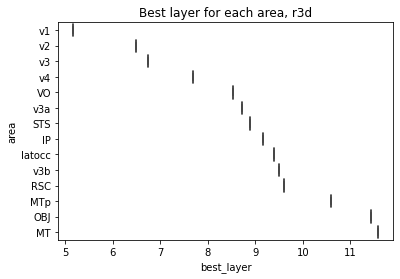

In [53]:
df__ = df_group.query('report_corr > .05').groupby('area').mean().sort_values('best_layer')
sns.boxplot(y='area', 
            x='best_layer', 
            data=df__.reset_index())
plt.title('Best layer for each area, r3d')

<AxesSubplot:xlabel='report_corr', ylabel='key'>

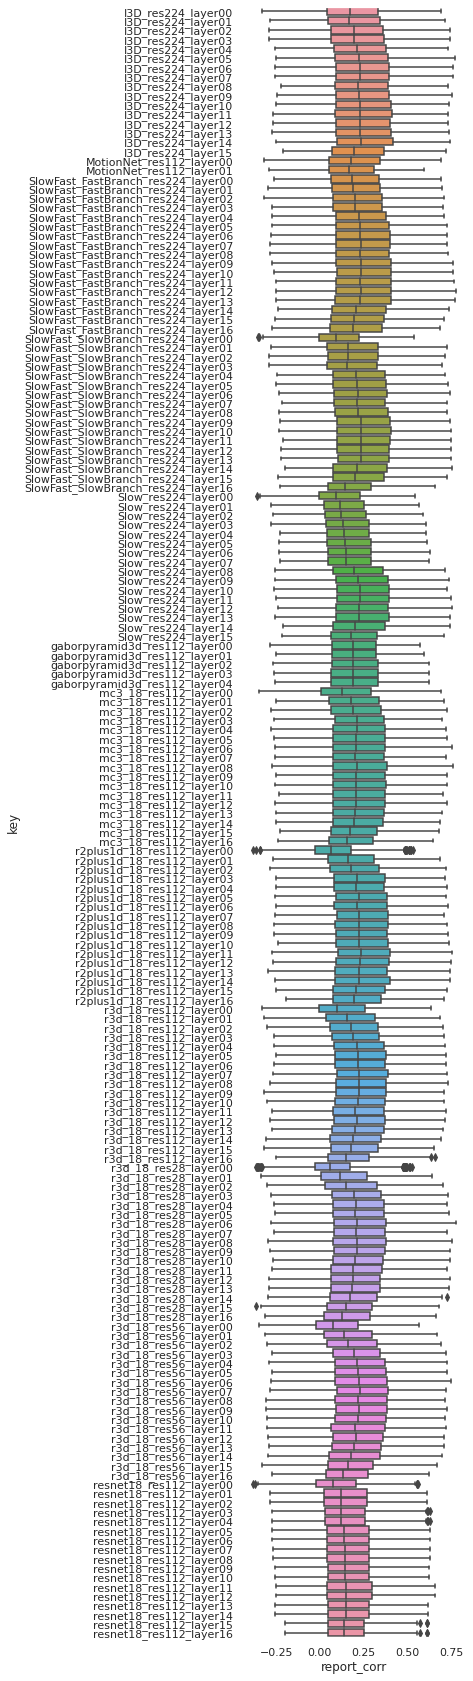

In [39]:
plt.figure(figsize=(4, 30))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.boxplot(y='key', 
            x='report_corr', 
            data=df, ax=plt.gca())

In [19]:
g = sns.catplot(y="key", x="report_corr",
                col="area",
                data=df,
                orient="h", aspect=.6, height=6, palette="Set3",
                kind="box")

(1571850, 3)

In [137]:
import pandas as pd
import seaborn as sns

#plt.figure(figsize=(4, 6))
#sns.boxplot(y='key', x='report_corr', data=df, ax=plt.gca(), hue='area')

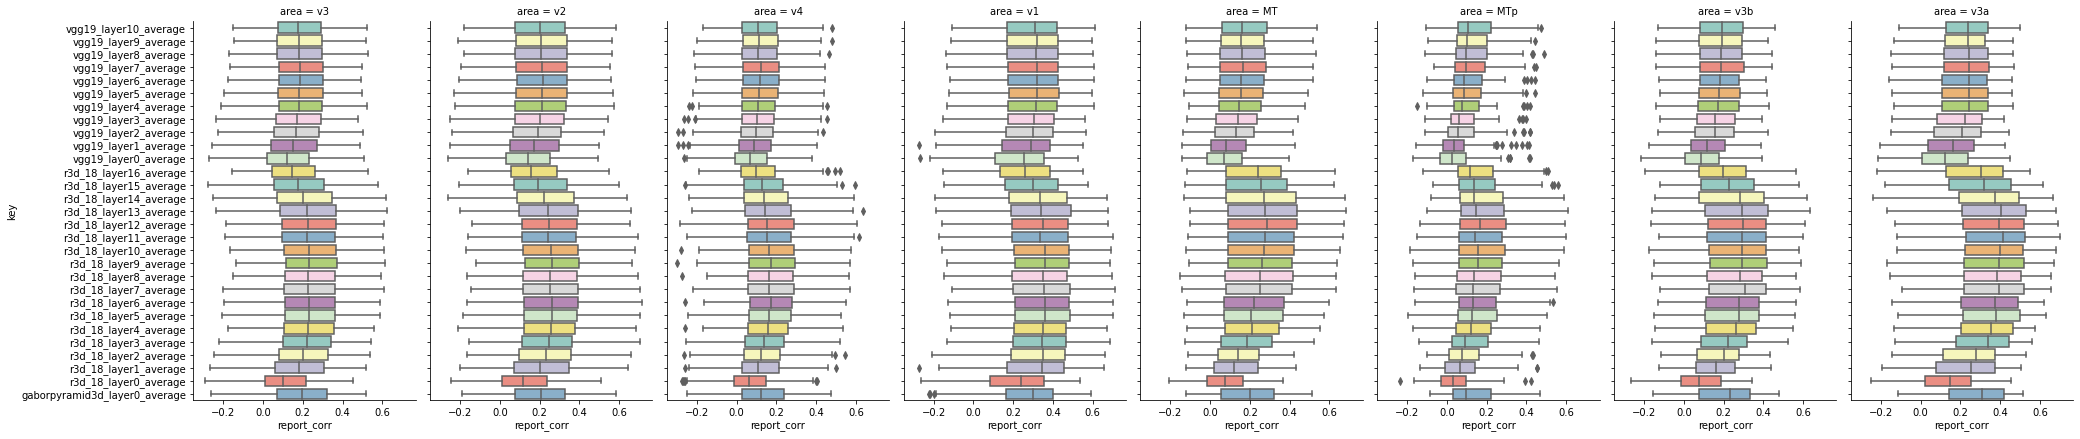

In [138]:
g = sns.catplot(y="key", x="report_corr",
                col="area",
                data=df,
                orient="h", aspect=.6, height=6, palette="Set3",
                kind="box")

In [55]:
from wandb.apis.internal import Api
a = Api()
a.download_urls

r3d_18_layer17_average:0.173
r3d_18_layer16_average:0.199
r3d_18_layer15_average:0.222
r3d_18_layer14_average:0.238
r3d_18_layer13_average:0.241
r3d_18_layer12_average:0.239
r3d_18_layer11_average:0.244
r3d_18_layer10_average:0.249
r3d_18_layer9_average:0.240
r3d_18_layer8_average:0.245
r3d_18_layer7_average:0.240
r3d_18_layer6_average:0.239
r3d_18_layer5_average:0.231
r3d_18_layer4_average:0.219
r3d_18_layer3_average:0.200
r3d_18_layer2_average:0.185
r3d_18_layer1_average:0.110


Text(0.5, 1.0, 'R3D_18 mean report correlation, vim2, map average')

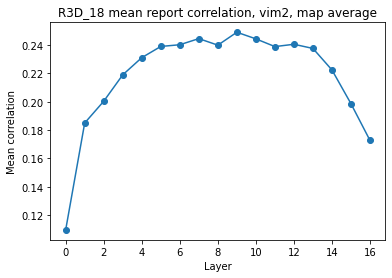

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def mean_from_hist(data):
    x_mean = data['packedBins']['min'] + np.arange(data['packedBins']['count']) * data['packedBins']['size']
    #x_mean = (x_mean[:-1] + x_mean[1:])/2
    the_mean = (x_mean * np.array(data['values'])).sum() / np.array(data['values']).sum()
    return the_mean

ms = []
for key, val in archives.items():
    m = mean_from_hist(val['corrs_report'])
    print(f"{key}:{m:.3f}")
    ms.append(m)
    
plt.plot(np.arange(17), np.array(ms)[::-1], 'o-')
plt.xlabel('Layer')
plt.ylabel('Mean correlation')
plt.title('R3D_18 mean report correlation, vim2, map average')

(-1.1, 1.1)

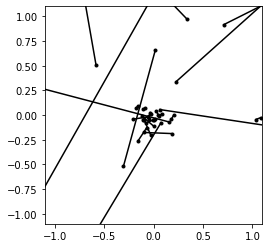

In [171]:
x_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wx'].cpu().numpy()
x_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wx'].cpu().numpy() for x in range(25)]).squeeze()
y_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wy'].cpu().numpy()
y_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wy'].cpu().numpy() for x in range(25)]).squeeze()
#archives['gaborpyramid2d'][0]['config']['learning_rate']
plt.plot(np.stack([x_all_at_once, x_one_by_one], axis=0), 
         np.stack([y_all_at_once, y_one_by_one], axis=0), 'k.-')
plt.axis('square')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

In [166]:
[x_all_at_once, x_one_by_one]

[array([ 0.18238145,  1.0866314 ,  0.00759659, -0.10613997, -0.71515685,
        -1.459469  ,  1.3236212 , -0.05640861, -0.04596966,  0.34030446,
         2.143676  ,  0.709235  , -0.11134848,  0.00410185,  0.02657548,
        -1.3330803 , -1.6518818 , -0.09665827,  0.08307133, -0.0694584 ,
        -0.30469847, -0.17413002, -1.0483379 ,  0.20523083, -0.07756416],
       dtype=float32),
 array([[-9.9157296e-02],
        [ 1.0336617e+00],
        [-1.2724528e-03],
        [-8.6366288e-02],
        [-5.8164388e-01],
        [ 3.1989318e-01],
        [ 2.2802328e-01],
        [-2.0692144e-01],
        [-3.3334795e-02],
        [-1.0469531e+00],
        [ 6.3262224e-02],
        [ 3.3106732e+00],
        [-2.7937867e-02],
        [-1.1491196e-01],
        [ 4.8468444e-02],
        [ 1.5786837e-01],
        [-1.2929194e+00],
        [-3.0077750e-02],
        [ 5.9524819e-02],
        [-1.5480994e-01],
        [ 1.7667795e-02],
        [-1.5860979e-01],
        [ 7.5761326e-02],
        [ 1.8

Tune correlation, all at once, xception2d: 0.1235
Tune correlation, cell-by-cell, xception2d: 0.1751


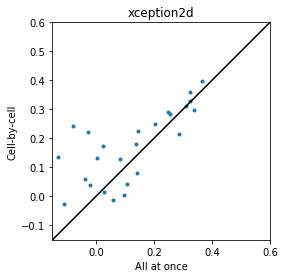

Tune correlation, all at once, gaborpyramid2d: 0.1656
Tune correlation, cell-by-cell, gaborpyramid2d: 0.1860


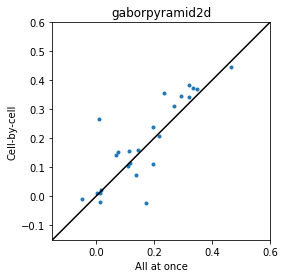

In [143]:
import matplotlib.pyplot as plt

for rep in ['xception2d', 'gaborpyramid2d']:
    tune_corr_all = archives[rep][-1]['tune_corr']
    tune_corr_cell_by_cell = [(k, v['tune_corr']) for k, v in archives[rep].items() if k > -1]
    tune_corr_cell_by_cell = [x[1] for x in sorted(tune_corr_cell_by_cell)]
    plt.plot(tune_corr_all, tune_corr_cell_by_cell, '.')
    plt.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    plt.xlim((-.15, .6))
    plt.ylim((-.15, .6))
    plt.xlabel('All at once')
    plt.ylabel('Cell-by-cell')
    plt.title(rep)
    print(f"Tune correlation, all at once, {rep}: {np.mean(tune_corr_all):.4f}")
    print(f"Tune correlation, cell-by-cell, {rep}: {np.mean(tune_corr_cell_by_cell):.4f}")
    plt.show()

1
2
3
4
5
6
7
8
9


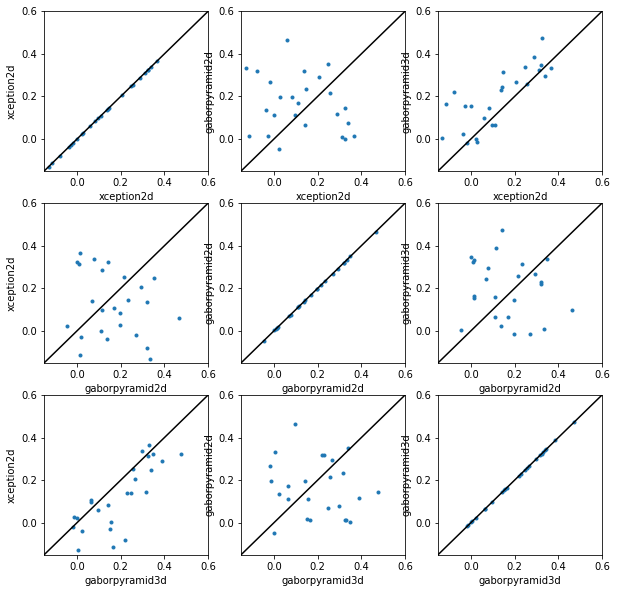

In [187]:
plt.figure(figsize=(10, 10))
reps = ['xception2d', 'gaborpyramid2d', 'gaborpyramid3d']
nrep = 3
for i in range(nrep):
    for j in range(0, nrep):
        rep0 = reps[i]
        rep1 = reps[j]
        plt.subplot(nrep, nrep, 1 + j + i * nrep)
        print(1 + j + i * nrep)
        plt.plot(archives[rep0][-1]['tune_corr'], archives[rep1][-1]['tune_corr'], '.')
        plt.xlabel(rep0)
        plt.ylabel(rep1)
        plt.plot([-1, 1], [-1, 1], 'k-')
        plt.xlim((-.15, .6))
        plt.ylim((-.15, .6))

#for rep in ['xception2d', 'gaborpyramid2d']:
#    tune_corr_all = archives[rep][-1]['tune_corr']

(-0.12, 0.5)

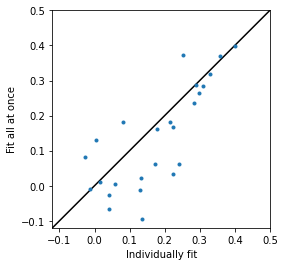

In [112]:
all_at_once = [0.1678023338317871,
               0.37069717049598694,
               0.2859063744544983,
               0.16201408207416534,
               0.1804608851671219,
               0.08193636685609818,
               0.28480473160743713,
               0.18251098692417145,
               0.1291564702987671,
               0.3979525566101074,
               0.26405853033065796,
               0.03389165922999382,
               0.2364319413900375,
               0.0045745414681732655,
               0.02219552919268608,
               -0.06534221768379211,
               0.31926828622817993,
               -0.010949542745947838,
               -0.00940705556422472,
               0.37300461530685425,
               0.01107801217585802,
               -0.094401553273201,
               0.062314119189977646,
               0.06088846176862717,
               -0.027850590646266937]

all_at_once_pretrained = [0.146110400557518,0.32512882351875305,0.2490551471710205,0.13805796205997467,0.2879319489002228,-0.11183082312345503,0.31194233894348145,0.141983300447464,0.0982915461063385,0.36537039279937744,0.3389202356338501,-0.026962850242853165,0.25463470816612244,-0.03682025149464607,0.001990905497223139,0.10854241251945496,0.3230203688144684,0.0827552080154419,0.059587348252534866,0.2049235701560974,0.02760285697877407,-0.12945596873760223,0.02471204660832882,-0.0783606693148613,-0.01916531473398209]
individual = np.array([x['tune_corr'] for x in archives.values()])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.plot(individual[::-1], all_at_once, '.')
plt.xlabel('Individually fit')
plt.ylabel('Fit all at once')
plt.axis('square')
plt.xlim((-0.12, 0.5))
plt.ylim((-0.12, 0.5))

In [114]:
np.mean(all_at_once_pretrained)

0.12351862573996186

In [94]:
import numpy as np

targets = sorted([(v['tune_corr'], v['weights']) for v in archives.values()])[:-17:-1]
ws = []
for _, vals in targets:
    idx = np.argsort(np.random.rand(8))[:4:]
    ws.append(vals['subnet.conv1.weight'][idx, :, :, :].cpu().detach().numpy())

W = np.concatenate(ws, axis=0)
np.save('pretrained/gaborpyramid2d.npy', W)

In [56]:
model_file.mode = 'rb'
model_file

<_io.TextIOWrapper name='D:\\Documents\\brain-scorer\\model.pt' mode='rb' encoding='cp1252'>

In [93]:
len(ws)

15

In [38]:
f = i.file('model.pt')
f.

{'_step': 0, '_runtime': 1, 'tune_corr': 0.04770519211888313, '_timestamp': 1608354193}